In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

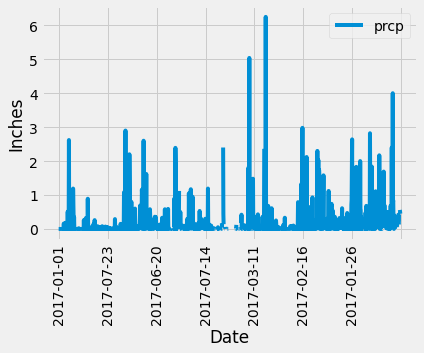

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = session.query(Measurement.station,Measurement.date,Measurement.prcp, Measurement.tobs).\
filter(Measurement.date > '2016-12-31')
# for row in query.limit(20).all():
#     print(row)

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > '2016-12-31')
# for row in query.all():
#     print(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
stmt = query.statement
df = pd.read_sql_query(stmt, session.bind)
df.set_index('date')
df.head(30)
# Sort the dataframe by date
# NOTE: By default, the table has already been uploaded in ascending order with statement above.

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='prcp', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


In [12]:
# Inspect the Stations Table to see the different columns in the database
inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types for Station table
columns = inspector.get_columns('Station')
for column in columns:
    print(column['name'],column['type'])
    
# Get a list of column names and types for Measurement table
columns = inspector.get_columns('Measurement')
print('------------------------------------')
for column in columns:
    print(column['name'],column['type'])    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
------------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#selecting everyone from those tables, and printing the values 
# join = session.query(Measurement,Station).filter(Measurement.station == Station.station).limit(10).all()
# for record in join:
#     (Measurement,Station) = record
#     print(Measurement.station, Station.station,Station.name)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()
# query = session.query(Station.station,Station.name,Station.latitude, Station.longitude,Station.elevation)
# print(query)
# for row in query.all():
#     print(row)

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all() 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Most_Active_Station = []
max_temp = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
min_temp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
# min_temp
avg_temp = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
# avg_temp
Most_Active_Station.append(f'The maximum temperature is: {max_temp}')
Most_Active_Station.append(f'The minimum temperature is : {min_temp}')
Most_Active_Station.append(f'The Minimum temperature is: {avg_temp}')
Most_Active_Station

['The maximum temperature is: [(85.0,)]',
 'The minimum temperature is : [(54.0,)]',
 'The Minimum temperature is: [(71.66378066378067,)]']

In [27]:
reduced_range = dt.date(2017, 8, 23) - dt.timedelta(days=365)
reduced_range

datetime.date(2016, 8, 23)

Text(0.5, -1.340000000000014, 'Temperature')

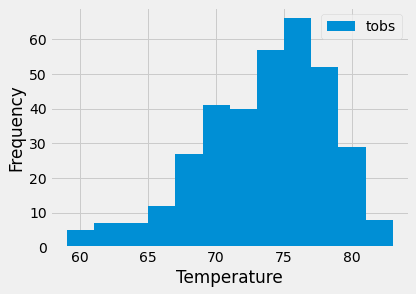

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
reduced_range = dt.date(2017, 8, 23) - dt.timedelta(days=365)

query = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date > reduced_range).all()

df = pd.DataFrame(query, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
